Loading the newest listings CSV and standardize column names.

In [21]:
import pandas as pd
import glob

data_dir = "../ml/data/"

listings_path = sorted(
    glob.glob(data_dir + "clean_sales_listings_*.csv")
)[-1]

df = pd.read_csv(listings_path)

# lowercase columns (important)
df.columns = [c.lower() for c in df.columns]

print("Loaded df:", df.shape)


Loaded df: (13428, 28)


Target variable : days_on_market_capped and useful predictors (logs, date parts, county comparisons).

In [22]:
import numpy as np

# Cap target again (must exist in THIS notebook)
df = df[df["days_on_market"].notna() & (df["days_on_market"] > 0)]

df["days_on_market_capped"] = df["days_on_market"].clip(
    upper=df["days_on_market"].quantile(0.99)
)

# Feature engineering (must be re-run)
df["listed_year"] = pd.to_datetime(df["listed_date"], errors="coerce").dt.year
df["listed_month"] = pd.to_datetime(df["listed_date"], errors="coerce").dt.month
df["listed_dayofweek"] = pd.to_datetime(df["listed_date"], errors="coerce").dt.dayofweek

df["log_price"] = np.log1p(df["current_price"])
df["log_sqft"] = np.log1p(df["square_footage"])

df["price_per_sqft_calc"] = df["current_price"] / df["square_footage"]
df["price_per_sq_ft"] = df["price_per_sq_ft"].fillna(df["price_per_sqft_calc"])

df["county_avg_price"] = df.groupby("county")["current_price"].transform("mean")
df["price_vs_county_avg"] = df["current_price"] / df["county_avg_price"]

df["county_avg_ppsf"] = df.groupby("county")["price_per_sq_ft"].transform("mean")
df["ppsf_vs_county_avg"] = df["price_per_sq_ft"] / df["county_avg_ppsf"]


In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


defining the target variable 

In [24]:
y = df["days_on_market_capped"]


If we list this property today, based on its price, location, and type, how long is it likely to stay unsold?

It helps the company:

Spot slow listings early

Detect overpriced properties

Adjust pricing strategy before revenue is lost

Understand which areas or property types are underperforming

In [ ]:
drop_cols = [
    "days_on_market",
    "days_on_market_capped",
    "listing_id",
    "address",
    "street",
    "mls_number",
    "agent_id",
    "office_id",
    "removed_date",
    "last_seen_ts",
    "status"
] #Remove columns that leak the answer or aren’t useful.

X = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Feature shape:", X.shape)


Feature shape: (13428, 28)


In [26]:
import numpy as np

# Replace infinity values caused by divisions
X = X.replace([np.inf, -np.inf], np.nan)

# Fill missing numeric values
num_cols_all = X.select_dtypes(include=["int64", "float64"]).columns
X[num_cols_all] = X[num_cols_all].fillna(X[num_cols_all].median())

# Fill missing categorical values
cat_cols_all = X.select_dtypes(include=["object", "category"]).columns
X[cat_cols_all] = X[cat_cols_all].fillna("Unknown")


C:\Users\A\AppData\Local\Temp\ipykernel_18624\2995909386.py:11: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols_all = X.select_dtypes(include=["object", "category"]).columns


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (10742, 28)
X_test : (2686, 28)


In [28]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))
print("\nNumeric columns:\n", num_cols.tolist())
print("\nCategorical columns:\n", cat_cols.tolist())


Numeric features: 18
Categorical features: 7

Numeric columns:
 ['zip_code', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'square_footage', 'lot_size', 'year_built', 'current_price', 'hoa_fee', 'price_per_sq_ft', 'log_price', 'log_sqft', 'price_per_sqft_calc', 'county_avg_price', 'price_vs_county_avg', 'county_avg_ppsf', 'ppsf_vs_county_avg']

Categorical columns:
 ['unit', 'city', 'county', 'property_type', 'listing_type', 'listed_date', 'created_date']


C:\Users\A\AppData\Local\Temp\ipykernel_18624\3122411251.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object", "category"]).columns


Removed raw date strings so OneHotEncoder doesn’t explode with too many unique values.

In [31]:
date_cols = ["listed_date", "created_date"]

X_train = X_train.drop(columns=[c for c in date_cols if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in date_cols if c in X_test.columns])


In [35]:
# Recompute column lists AFTER dropping date columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category", "string"]).columns

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))
print("Categorical columns:", cat_cols.tolist())


Numeric features: 18
Categorical features: 5
Categorical columns: ['unit', 'city', 'county', 'property_type', 'listing_type']


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf)
    ]
)


In [ ]:
model.fit(X_train, y_train)
print("Model trained successfully!")


✅ Model trained successfully!


predict on test data 

In [38]:
# Predict on test data
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n=== DOM Model Performance ===")
print(f"MAE : {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R²  : {r2:.3f}")



=== DOM Model Performance ===
MAE : 44.08 days
RMSE: 80.99 days
R²  : 0.593


MAE: 44 days
→ On average, the model’s prediction is about 44 days off from the actual time a property stays on the market.

RMSE: 81 days
→ Larger errors exist for a small number of listings , which is expected in real estate data.

R²: 0.59
→ The model explains about 59% of the factors that influence how long a property stays on the market.

Visualizations of the results 

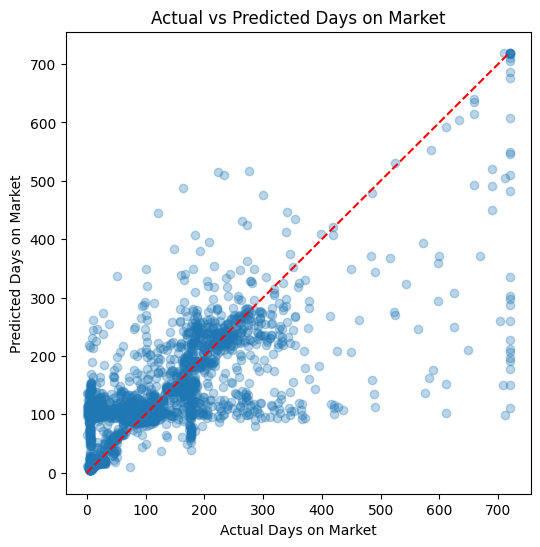

In [39]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("Actual Days on Market")
plt.ylabel("Predicted Days on Market")
plt.title("Actual vs Predicted Days on Market")
plt.show()


model is fairly good at predicting normal listings, but it’s less accurate for unusual properties that sit on the market for a very long time.

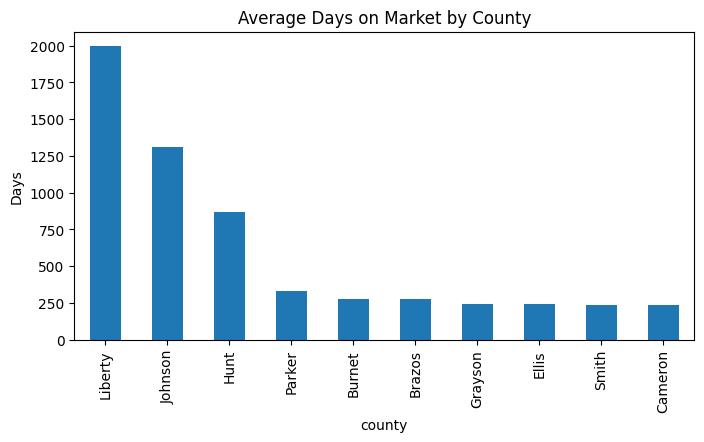

In [40]:
county_dom = df.groupby("county")["days_on_market"].mean().sort_values(ascending=False).head(10)

county_dom.plot(kind="bar", figsize=(8,4), title="Average Days on Market by County")
plt.ylabel("Days")
plt.show()


Where a property is located strongly affects how fast it sells.

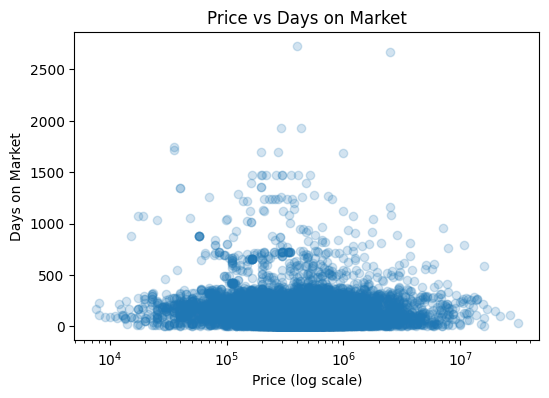

In [41]:
plt.figure(figsize=(6,4))
plt.scatter(df["current_price"], df["days_on_market"], alpha=0.2)
plt.xscale("log")
plt.xlabel("Price (log scale)")
plt.ylabel("Days on Market")
plt.title("Price vs Days on Market")
plt.show()


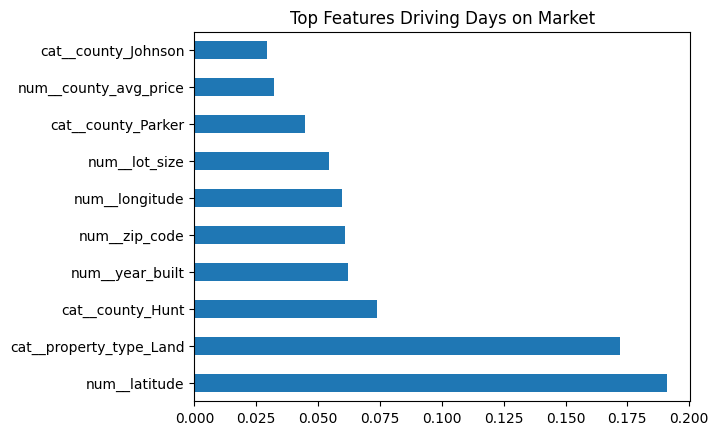

In [42]:
import pandas as pd

feature_names = model.named_steps["preprocessor"].get_feature_names_out()
importances = model.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)
fi.plot(kind="barh", title="Top Features Driving Days on Market")
plt.show()


The model that predicts how long a property will stay on the market with reasonable accuracy, showed that location and property type matter most, and produced visuals that clearly explain both performance and business impact

Analaysisng the best model for our data 

In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

# --- Preprocess properly (imputer inside pipeline = safer) ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

def eval_model(model, name):
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.2f} days")
    print(f"RMSE: {rmse:.2f} days")
    print(f"R²  : {r2:.3f}")
    return pipe, mae, rmse, r2

models = [
    ("RandomForest (current)", RandomForestRegressor(
        n_estimators=400, max_depth=25, min_samples_leaf=3,
        random_state=42, n_jobs=-1
    )),
    ("ExtraTrees", ExtraTreesRegressor(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    )),
    ("HistGradientBoosting", HistGradientBoostingRegressor(
        max_depth=10, learning_rate=0.08, max_iter=400,
        random_state=42
    ))
]

results = []
trained = {}

for name, m in models:
    pipe, mae, rmse, r2 = eval_model(m, name)
    results.append((name, mae, rmse, r2))
    trained[name] = pipe

# Show best by MAE
results_sorted = sorted(results, key=lambda x: x[1])
print("\n Best by MAE:", results_sorted[0])



=== RandomForest (current) ===
MAE : 43.36 days
RMSE: 80.76 days
R²  : 0.596

=== ExtraTrees ===
MAE : 42.38 days
RMSE: 81.82 days
R²  : 0.585

=== HistGradientBoosting ===
MAE : 46.04 days
RMSE: 81.19 days
R²  : 0.591

🏆 Best by MAE: ('ExtraTrees', 42.3814127971639, np.float64(81.81657331973823), 0.5851193466660989)


In [44]:
# Get feature names after preprocessing
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Get feature importances from ExtraTrees
importances = model.named_steps["model"].feature_importances_

# Create importance dataframe
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Show top drivers
feat_imp.head(15)


,feature,importance
1,num__latitude,0.190907
1549,cat__property_type_Land,0.172055
1536,cat__county_Hunt,0.073981
7,num__year_built,0.062006
0,num__zip_code,0.060735
2,num__longitude,0.059610
6,num__lot_size,0.054505
1542,cat__county_Parker,0.044860
14,num__county_avg_price,0.032078
1537,cat__county_Johnson,0.029342


1. num _lat :Where the property is (north/south in Texas) strongly affects how fast it sells
2. If a listing is Land, the model treats it very differently,Land typically stays on the market much longer
3. Each county has its own market speed which means county has its own market speed
4. Newer homes sell faster : Newer construction → lower DOM Older homes → longer DOM
5. The average price in the county affects how fast any listing sells

Predict DOM on the test set

In [54]:
import numpy as np
import pandas as pd

# Predict on test set
y_pred = model.predict(X_test)

# Quick check
print("Predictions created:", len(y_pred))
print("Pred DOM sample:", y_pred[:5])


Predictions created: 2686
Pred DOM sample: [ 18.56549751 180.28457218  35.49543874  89.45972582 216.17885985]


Creating a risk score 

In [68]:
import pandas as pd

risk_df = X_test.copy()

risk_df["pred_dom"] = y_pred

risk_df["risk_level"] = pd.cut(
    risk_df["pred_dom"],
    bins=[-1, 60, 120, 10000],
    labels=["Low", "Medium", "High"]
)

risk_df["risk_score_0_100"] = (
    risk_df["pred_dom"] / risk_df["pred_dom"].max() * 100
)

risk_df.head()


,unit,city,county,zip_code,latitude,longitude,property_type,bedrooms,bathrooms,square_footage,...,log_price,log_sqft,price_per_sqft_calc,county_avg_price,price_vs_county_avg,county_avg_ppsf,ppsf_vs_county_avg,pred_dom,risk_level,risk_score_0_100
2069,Unknown,Nolanville,Bell,76559,31.062637,-97.626308,Single Family,4,3,2043,...,12.810118,7.622664,179.099364,373115.944345,0.980660,228.196676,0.0,18.565498,Low,2.582187
9482,Unknown,Midlothian,Ellis,76065,32.490345,-96.955626,Single Family,4,4,3138,...,13.100120,8.051660,155.831740,770936.781421,0.634293,228.196676,0.0,180.284572,High,25.074929
6330,Unknown,Fresno,Fort Bend,77545,29.517489,-95.453808,Land,0,0,0,...,12.269052,0.000000,204.904412,530801.040724,0.401280,228.196676,0.0,35.495439,Low,4.936893
1083,Unknown,La Marque,Galveston,77568,29.362786,-94.952345,Single Family,3,2,1832,...,11.695255,7.513709,65.502183,492595.008333,0.243608,228.196676,0.0,89.459726,Medium,12.442530
12010,Unit 20,Austin,Travis,78735,30.289722,-97.861903,Condo,4,4,3772,...,14.663523,8.235626,619.034995,896095.434097,2.605749,228.196676,0.0,216.178860,High,30.067296


In [69]:
# Put actual + predicted together for analysis
results = X_test.copy()
results["actual_dom"] = y_test.values
results["pred_dom"] = y_pred

# Risk label rules (you can adjust thresholds if your team wants)
# Low: <= 60 days
# Medium: 61–120 days
# High: > 120 days
bins = [-np.inf, 60, 120, np.inf]
labels = ["Low", "Medium", "High"]

results["risk_level"] = pd.cut(results["pred_dom"], bins=bins, labels=labels)

print(results[["pred_dom", "actual_dom", "risk_level"]].head(10))
print("\nRisk distribution:\n", results["risk_level"].value_counts())


         pred_dom  actual_dom risk_level
2069    18.565498        31.0        Low
9482   180.284572       290.0       High
6330    35.495439        22.0        Low
1083    89.459726        73.0     Medium
12010  216.178860       160.0       High
13167   93.833001        86.0     Medium
11927  115.308489       111.0     Medium
7288     9.995287        10.0        Low
8452    18.397828        24.0        Low
12349  137.061717        85.0       High

Risk distribution:
 risk_level
High      996
Medium    960
Low       730
Name: count, dtype: int64


In [70]:

pred_dom_clipped = results["pred_dom"].clip(0, 365)

results["risk_score_0_100"] = (pred_dom_clipped / 365) * 100

print(results[["pred_dom", "risk_level", "risk_score_0_100"]].head(10))


         pred_dom risk_level  risk_score_0_100
2069    18.565498        Low          5.086438
9482   180.284572       High         49.393033
6330    35.495439        Low          9.724778
1083    89.459726     Medium         24.509514
12010  216.178860       High         59.227085
13167   93.833001     Medium         25.707671
11927  115.308489     Medium         31.591367
7288     9.995287        Low          2.738435
8452    18.397828        Low          5.040501
12349  137.061717       High         37.551155


In [71]:
# Create an index-safe copy of df with the same feature engineering columns available
df_reset = df.reset_index(drop=True)

# X was created from df after dropping columns, so X index maps to df index
# This re-attaches listing_id for the rows in X_test
results["listing_id"] = df_reset.loc[results.index, "listing_id"].values
results["county"] = df_reset.loc[results.index, "county"].values
results["city"] = df_reset.loc[results.index, "city"].values
results["property_type"] = df_reset.loc[results.index, "property_type"].values
results["current_price"] = df_reset.loc[results.index, "current_price"].values

results[["listing_id","county","city","property_type","current_price","pred_dom","risk_level","risk_score_0_100"]].head(10)


,listing_id,county,city,property_type,current_price,pred_dom,risk_level,risk_score_0_100
2069,e518ec079b557d80,Bell,Nolanville,Single Family,365900,18.565498,Low,5.086438
9482,05b25616e31a283d,Ellis,Midlothian,Single Family,489000,180.284572,High,49.393033
6330,f75f962725c7a418,Fort Bend,Fresno,Land,213000,35.495439,Low,9.724778
1083,0c60d64f9288919a,Galveston,La Marque,Single Family,120000,89.459726,Medium,24.509514
12010,5e9bf49f2ed10f79,Travis,Austin,Condo,2335000,216.178860,High,59.227085
13167,476881ccbeba8747,Travis,Austin,Single Family,439000,93.833001,Medium,25.707671
11927,196a008fe5baac08,Travis,Austin,Single Family,395000,115.308489,Medium,31.591367
7288,735f19687399399b,Collin,Anna,Single Family,373268,9.995287,Low,2.738435
8452,f3433ea721218613,Bell,Bartlett,Land,2913500,18.397828,Low,5.040501
12349,4ca4cadb1fde0ec7,Travis,Austin,Condo,199000,137.061717,High,37.551155


In [72]:
results = results.copy()

results["overpriced_flag"] = (
    results["price_vs_county_avg"] > 1.1
)


In [73]:
def recommend_action(row):
    if row["risk_level"] == "High" and row["overpriced_flag"]:
        return "Reduce price – likely overpriced"
    elif row["risk_level"] == "High":
        return "Review listing – market or property type issue"
    elif row["risk_level"] == "Medium":
        return "Monitor closely"
    else:
        return "No action needed"

results["recommended_action"] = results.apply(recommend_action, axis=1)


In [74]:
results[[
    "county",
    "property_type",
    "current_price",
    "pred_dom",
    "risk_level",
    "price_vs_county_avg",
    "recommended_action"
]].head(10)


,county,property_type,current_price,pred_dom,risk_level,price_vs_county_avg,recommended_action
2069,Bell,Single Family,365900,18.565498,Low,0.980660,No action needed
9482,Ellis,Single Family,489000,180.284572,High,0.634293,Review listing – market or property type issue
6330,Fort Bend,Land,213000,35.495439,Low,0.401280,No action needed
1083,Galveston,Single Family,120000,89.459726,Medium,0.243608,Monitor closely
12010,Travis,Condo,2335000,216.178860,High,2.605749,Reduce price – likely overpriced
13167,Travis,Single Family,439000,93.833001,Medium,0.489903,Monitor closely
11927,Travis,Single Family,395000,115.308489,Medium,0.440801,Monitor closely
7288,Collin,Single Family,373268,9.995287,Low,0.769880,No action needed
8452,Bell,Land,2913500,18.397828,Low,7.808565,No action needed
12349,Travis,Condo,199000,137.061717,High,0.222075,Review listing – market or property type issue


In [75]:
output_path = "../reports/dom_risk_scoring_output.csv"

# ensure correct type for Streamlit merge
results["listing_id"] = results["listing_id"].astype(str)

results.to_csv(output_path, index=False)
print("Saved:", output_path)


Saved: ../reports/dom_risk_scoring_output.csv


In [76]:
pd.read_csv("../reports/dom_risk_scoring_output.csv").columns


Index(['unit', 'city', 'county', 'zip_code', 'latitude', 'longitude',
       'property_type', 'bedrooms', 'bathrooms', 'square_footage', 'lot_size',
       'year_built', 'current_price', 'hoa_fee', 'price_per_sq_ft',
       'listing_type', 'listed_year', 'listed_month', 'listed_dayofweek',
       'log_price', 'log_sqft', 'price_per_sqft_calc', 'county_avg_price',
       'price_vs_county_avg', 'county_avg_ppsf', 'ppsf_vs_county_avg',
       'actual_dom', 'pred_dom', 'risk_level', 'risk_score_0_100',
       'listing_id', 'overpriced_flag', 'recommended_action'],
      dtype='str')